## Capstone Project 1

This Jupyter Notebook documents the development of a Machine Learning project focused on predicting the price of Ford cars. The project aims to create a reliable and scalable solution for car price prediction using historical data, exploring patterns in features like mileage, year, and specifications.

## Project Overview

The objective is to predict the price of Ford cars based on their attributes. Accurate price predictions are crucial for car dealerships, online platforms, and individual sellers to make data-driven pricing decisions. This project provides a structured approach, from data exploration to model deployment, ensuring the solution is practical and usable.

### Data preparation

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import mutual_info_score, accuracy_score, roc_curve, roc_auc_score
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from tqdm.auto import tqdm
import pickle
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
import warnings

In [4]:
warnings.filterwarnings("ignore", category=FutureWarning)

### 1. Data Loading

In [5]:
data = pd.read_csv("ford_car_price_prediction.csv")
data.columns = data.columns.str.lower().str.replace(' ', '_')

## Basic overview

In [6]:
data_path = "ford_car_price_prediction.csv"
print("First 10 lines of the dataset:")
!head $data_path

First 10 lines of the dataset:
model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
 Fiesta,2017,12000,Automatic,15944,Petrol,150,57.7,1
 Focus,2018,14000,Manual,9083,Petrol,150,57.7,1
 Focus,2017,13000,Manual,12456,Petrol,150,57.7,1
 Fiesta,2019,17500,Manual,10460,Petrol,145,40.3,1.5
 Fiesta,2019,16500,Automatic,1482,Petrol,145,48.7,1
 Fiesta,2015,10500,Manual,35432,Petrol,145,47.9,1.6
 Puma,2019,22500,Manual,2029,Petrol,145,50.4,1
 Fiesta,2017,9000,Manual,13054,Petrol,145,54.3,1.2
 Kuga,2019,25500,Automatic,6894,Diesel,145,42.2,2


In [7]:
df = pd.read_csv(data_path)
df.head(10)

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,Fiesta,2017,12000,Automatic,15944,Petrol,150,57.7,1.0
1,Focus,2018,14000,Manual,9083,Petrol,150,57.7,1.0
2,Focus,2017,13000,Manual,12456,Petrol,150,57.7,1.0
3,Fiesta,2019,17500,Manual,10460,Petrol,145,40.3,1.5
4,Fiesta,2019,16500,Automatic,1482,Petrol,145,48.7,1.0
5,Fiesta,2015,10500,Manual,35432,Petrol,145,47.9,1.6
6,Puma,2019,22500,Manual,2029,Petrol,145,50.4,1.0
7,Fiesta,2017,9000,Manual,13054,Petrol,145,54.3,1.2
8,Kuga,2019,25500,Automatic,6894,Diesel,145,42.2,2.0
9,Focus,2018,10000,Manual,48141,Petrol,145,61.4,1.0


### 2. Exploratory Data Analysis (EDA)

In [10]:
print("\nColumns:", df.columns)
print(df.info())


Columns: Index(['model', 'year', 'price', 'transmission', 'mileage', 'fuelType', 'tax',
       'mpg', 'engineSize'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         1460 non-null   object 
 1   year          1460 non-null   int64  
 2   price         1460 non-null   int64  
 3   transmission  1460 non-null   object 
 4   mileage       1460 non-null   int64  
 5   fuelType      1460 non-null   object 
 6   tax           1460 non-null   int64  
 7   mpg           1460 non-null   float64
 8   engineSize    1460 non-null   float64
dtypes: float64(2), int64(4), object(3)
memory usage: 102.8+ KB
None


In [11]:
print(df.describe())

              year         price       mileage          tax          mpg  \
count  1460.000000   1460.000000   1460.000000  1460.000000  1460.000000   
mean   2016.993836  12280.198630  21907.027397   108.205479    58.609726   
std       1.632212   4447.710936  15874.464065    62.334075     9.577440   
min    2013.000000   3691.000000      5.000000     0.000000    20.900000   
25%    2016.000000   9000.000000  10174.000000    30.000000    54.300000   
50%    2017.000000  11199.000000  17863.500000   145.000000    58.900000   
75%    2018.000000  14998.000000  29859.750000   145.000000    65.700000   
max    2020.000000  42489.000000  88927.000000   570.000000    88.300000   

        engineSize  
count  1460.000000  
mean      1.361438  
std       0.436243  
min       1.000000  
25%       1.000000  
50%       1.200000  
75%       1.500000  
max       5.000000  


In [12]:
print("Missing values:\n", df.isnull().sum())

Missing values:
 model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
dtype: int64


In [16]:
target_label = "price"

In [20]:
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
if target_label in numeric_columns:
    numeric_columns.remove(target_label)

object_columns = df.select_dtypes(include=["object"]).columns.tolist()

X = df[numeric_columns]
y = df[target_label]
print("\nFeatures (X):", X.columns)
print("Target (y):", target_label)


Features (X): Index(['year', 'mileage', 'tax', 'mpg', 'engineSize'], dtype='object')
Target (y): price


### Plot Distributions for Numerical Columns


Boxplot of numeric columns:


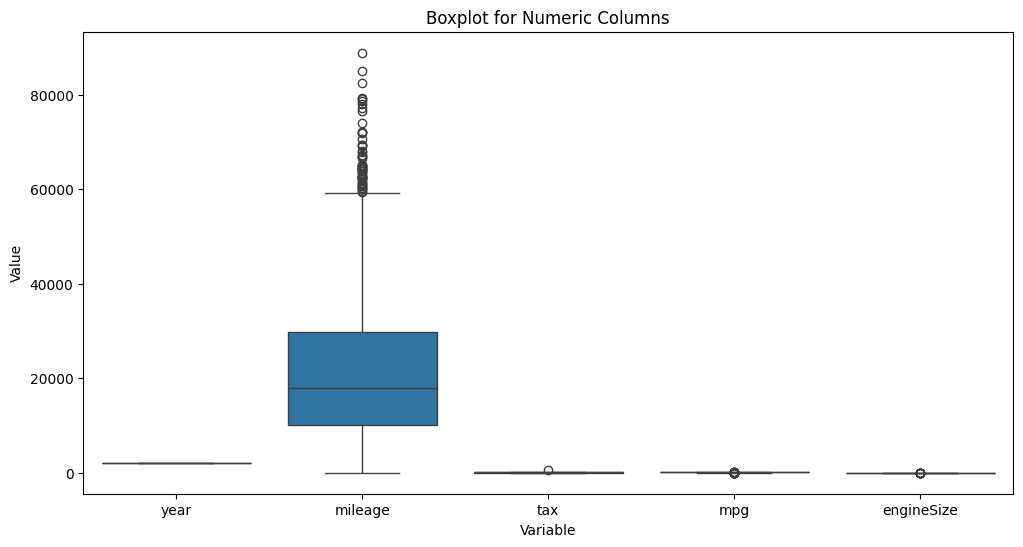

In [22]:
def showBoxplt(df_):
    df_melted = df_.melt(var_name="Variable", value_name="Value")
    plt.figure(figsize=(12, 6))
    sns.boxplot(x="Variable", y="Value", data=df_melted)
    plt.title("Boxplot for Numeric Columns")
    plt.show()

print("\nBoxplot of numeric columns:")
showBoxplt(df[numeric_columns])

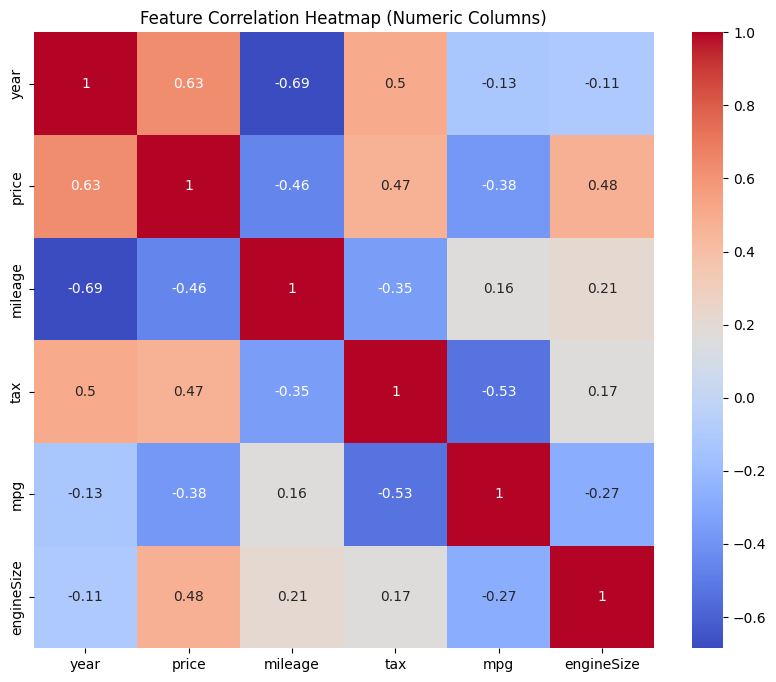

In [31]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap (Numeric Columns)")
plt.show()

In [32]:
numeric_cols = df.select_dtypes(include=[np.number]).columns

if target_label in numeric_cols:
    correlation_target = df[numeric_cols].corr()[target_label].sort_values(ascending=False)
    print("\nCorrelation with target:", target_label)
    print(correlation_target)
else:
    print(f"'{target_label}' is not in numeric columns. Please ensure the target is numeric.")


Correlation with target: price
price         1.000000
year          0.628646
engineSize    0.478156
tax           0.470569
mpg          -0.378478
mileage      -0.456676
Name: price, dtype: float64


### (A) Histogram of Price

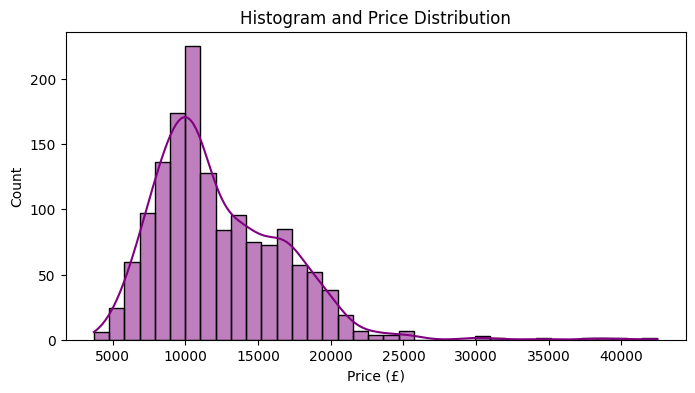

In [33]:
plt.figure(figsize=(8,4))
sns.histplot(data[target_label], kde=True, color='purple')
plt.title("Histogram and Price Distribution")
plt.xlabel("Price (£)")
plt.ylabel("Count")
plt.show()

### (B) Histograms/KDE of Numerical Columns

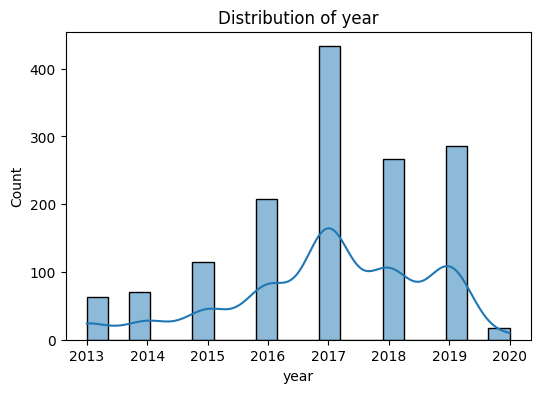

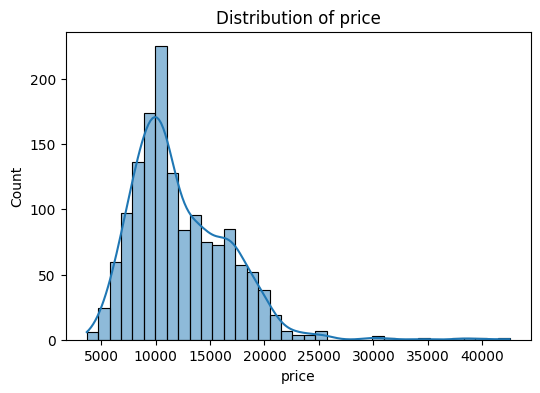

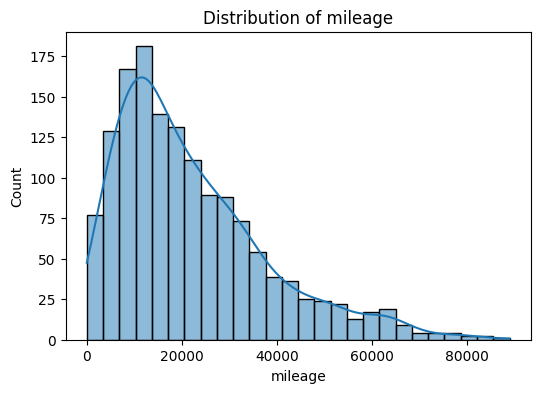

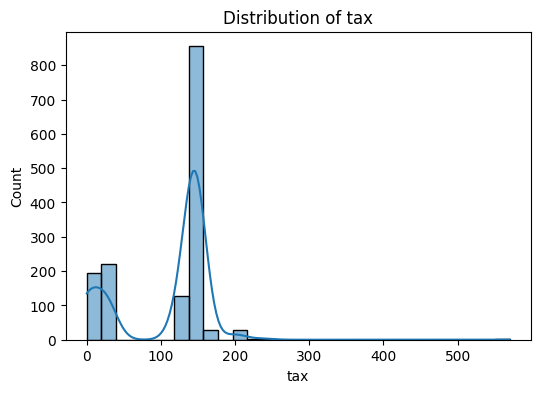

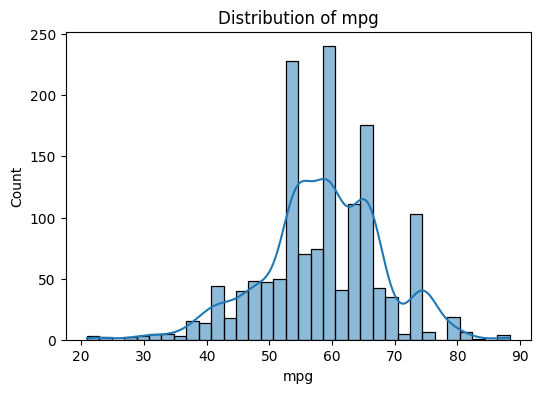

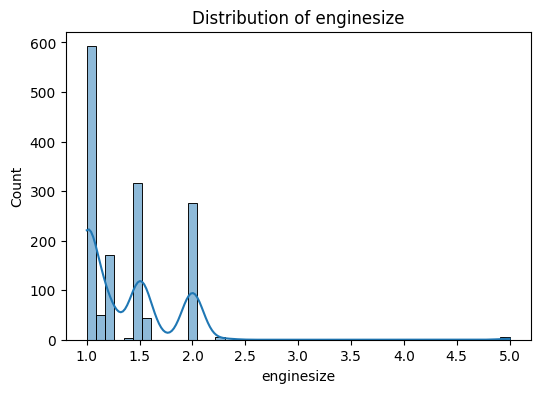

In [34]:
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()

for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(data[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

### (C) Countplot of a Categorical Feature (Example: Brand)

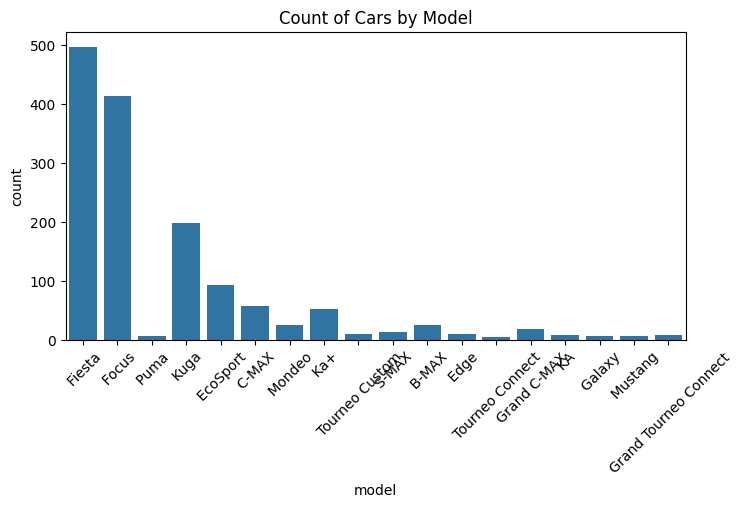

In [35]:
plt.figure(figsize=(8,4))
sns.countplot(x='model', data=data)
plt.title("Count of Cars by Model")
plt.xticks(rotation=45)
plt.show()

### (D) Violinplot: Brand vs. Price

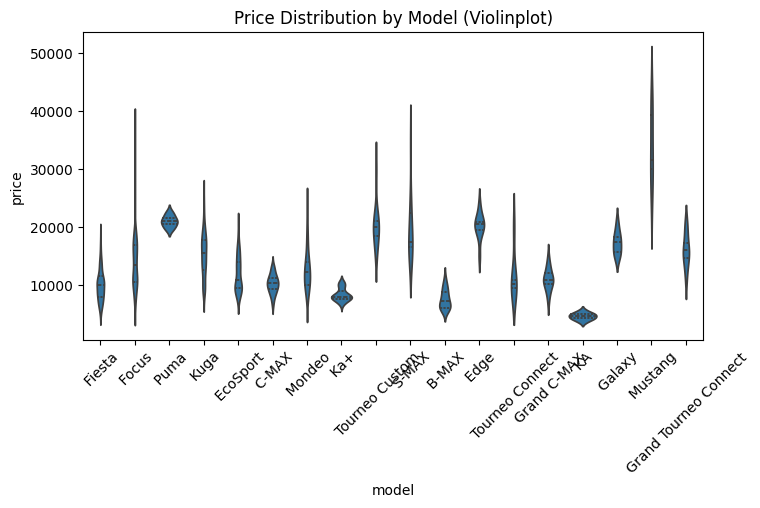

In [36]:
if 'model' in data.columns:
    plt.figure(figsize=(8, 4))
    sns.violinplot(
        x='model', 
        y=target_label, 
        data=data, 
        inner='quartile'
    )
    plt.title("Price Distribution by Model (Violinplot)")
    plt.xticks(rotation=45)
    plt.show()

### (E) Stripplot with Hue

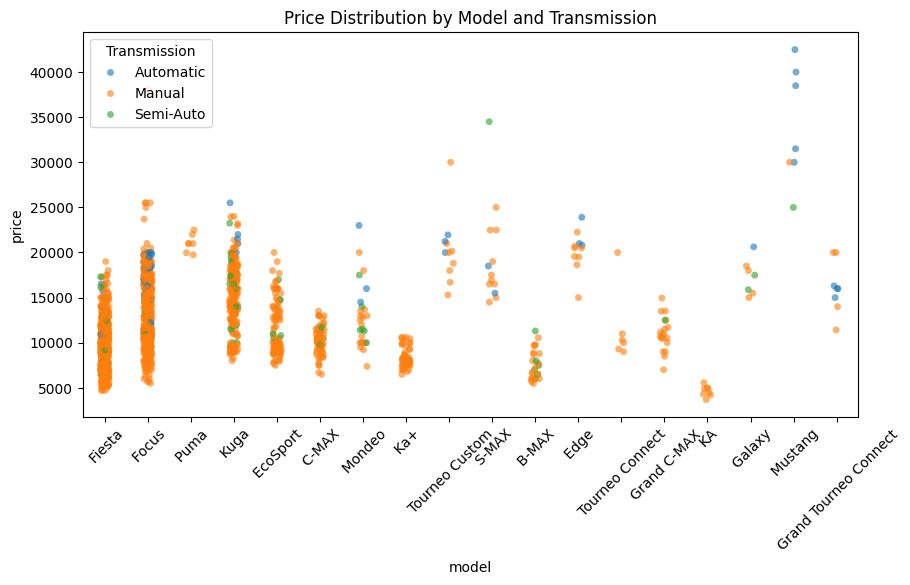

In [39]:
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()

if 'model' in categorical_cols and 'transmission' in categorical_cols:
    plt.figure(figsize=(10, 5))
    sns.stripplot(x='model', y='price', hue='transmission', data=data, jitter=True, alpha=0.6)
    plt.title("Price Distribution by Model and Transmission")
    plt.xticks(rotation=45)
    plt.legend(title='Transmission')
    plt.show()

### (F) Boxplot of mpg vs Brand (if both exist)

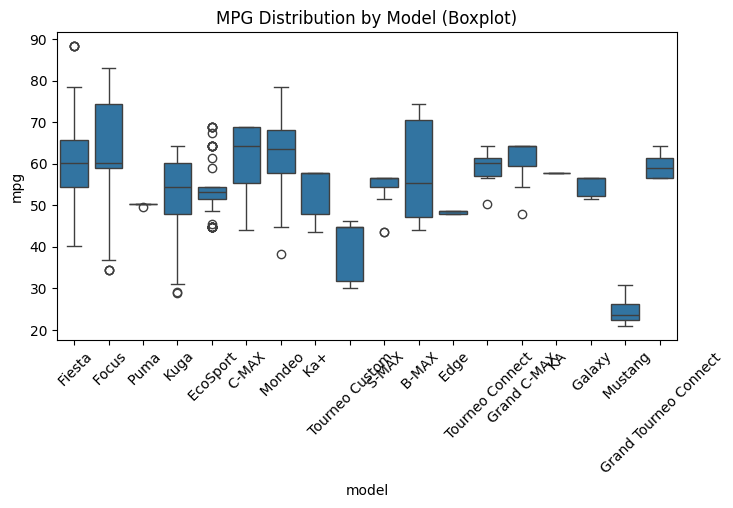

In [40]:
if 'model' in categorical_cols and 'mpg' in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='model', y='mpg', data=data)
    plt.title("MPG Distribution by Model (Boxplot)")
    plt.xticks(rotation=45)
    plt.show()

### (G) Scatterplot mpg vs price, hue=transmission

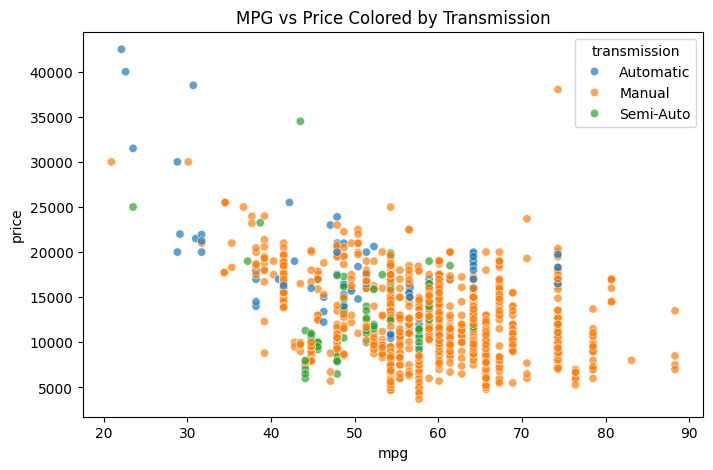

In [41]:
if 'mpg' in numerical_cols and 'transmission' in categorical_cols:
    plt.figure(figsize=(8,5))
    sns.scatterplot(x='mpg', y='price', hue='transmission', data=data, alpha=0.7)
    plt.title("MPG vs Price Colored by Transmission")
    plt.show()

### (H) Jointplot of Mileage vs. Price

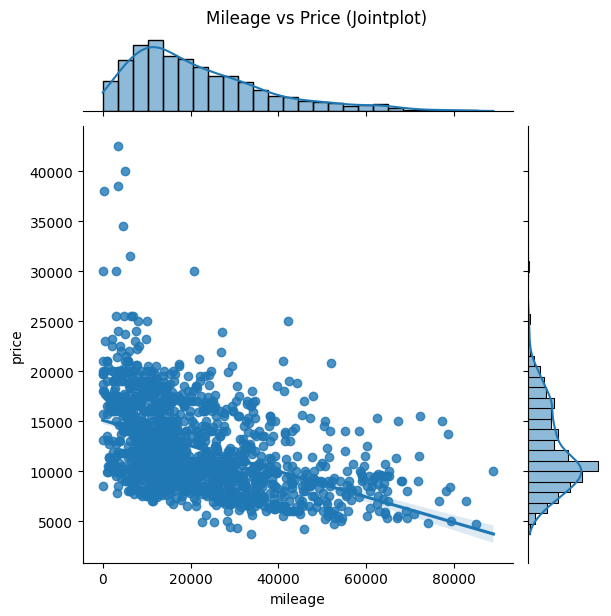

In [42]:
if 'mileage' in numerical_cols:
    sns.jointplot(x='mileage', y='price', data=data, kind='reg', height=6)
    plt.suptitle("Mileage vs Price (Jointplot)", y=1.02)
    plt.show()

### (I) Regplot of Engine Size vs Price

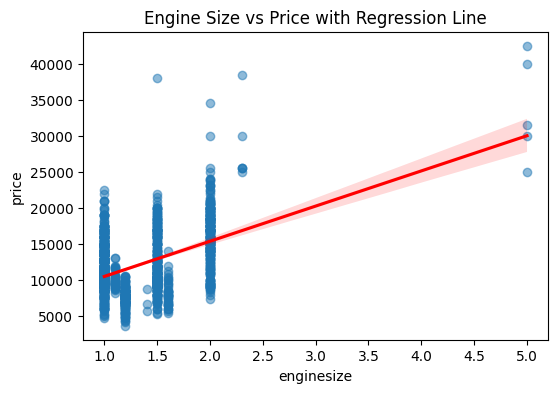

In [43]:
if 'enginesize' in numerical_cols:
    plt.figure(figsize=(6,4))
    sns.regplot(x='enginesize', y='price', data=data, scatter_kws={'alpha':0.5}, line_kws={"color":"red"})
    plt.title("Engine Size vs Price with Regression Line")
    plt.show()

### (J) Correlation Heatmap (Numerical + Price)

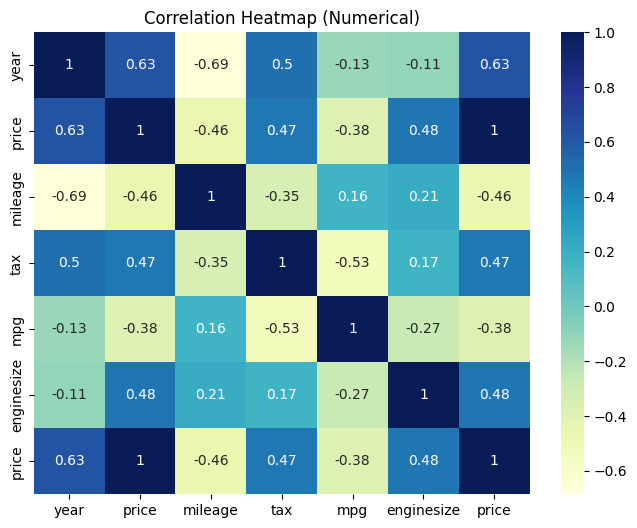

In [44]:
corr = data[numerical_cols + [target_label]].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='YlGnBu')
plt.title("Correlation Heatmap (Numerical)")
plt.show()

### (K) Line plot - Distribution of average price by year (year)

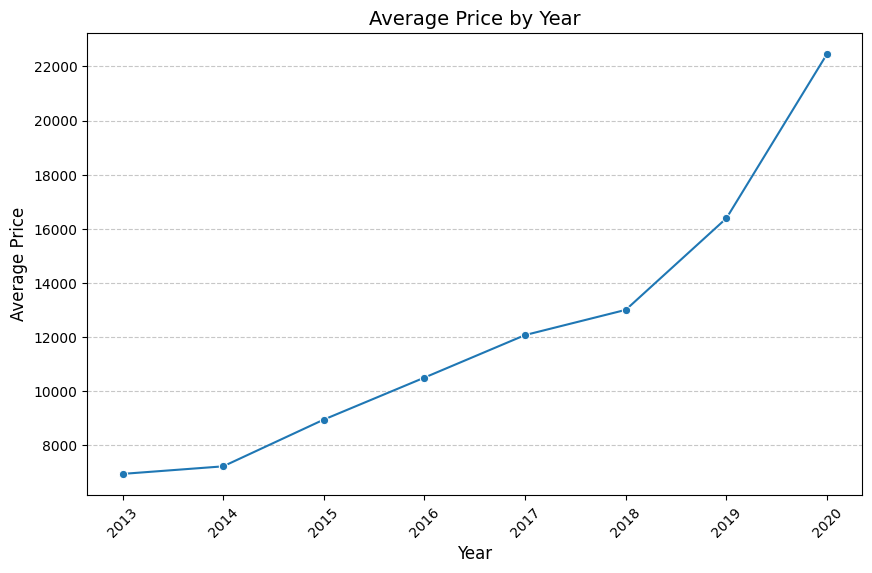

In [45]:
if 'year' in data.columns and 'price' in data.columns:
    plt.figure(figsize=(10, 6))

    year_price_mean = data.groupby('year')['price'].mean().sort_index()

    sns.lineplot(x=year_price_mean.index, y=year_price_mean.values, marker='o')
    plt.title("Average Price by Year", fontsize=14)
    plt.xlabel("Year", fontsize=12)
    plt.ylabel("Average Price", fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    plt.show()

### (L) Scatter Plot - Price vs Mileage

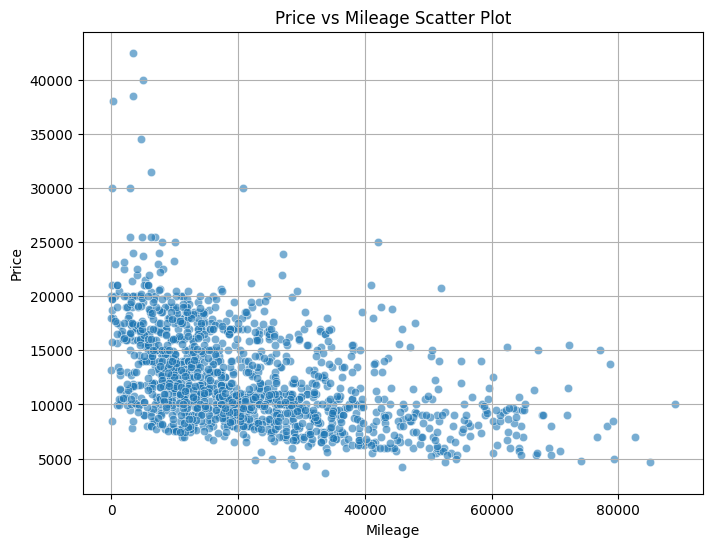

In [46]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='mileage', y='price', data=data, alpha=0.6)
plt.title("Price vs Mileage Scatter Plot")
plt.xlabel("Mileage")
plt.ylabel("Price")
plt.grid(True)
plt.show()

### Remove Outliers

In [47]:
def remove_outliers_iqr(df, column):

    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return filtered_df

numerical_cols_to_process = ['price', 'mileage', 'tax', 'mpg', 'engineSize']

for col in numerical_cols_to_process:
    if col in df.columns:
        df = remove_outliers_iqr(df, col)

print("Outliers removed for the specified numerical columns.")

Outliers removed for the specified numerical columns.


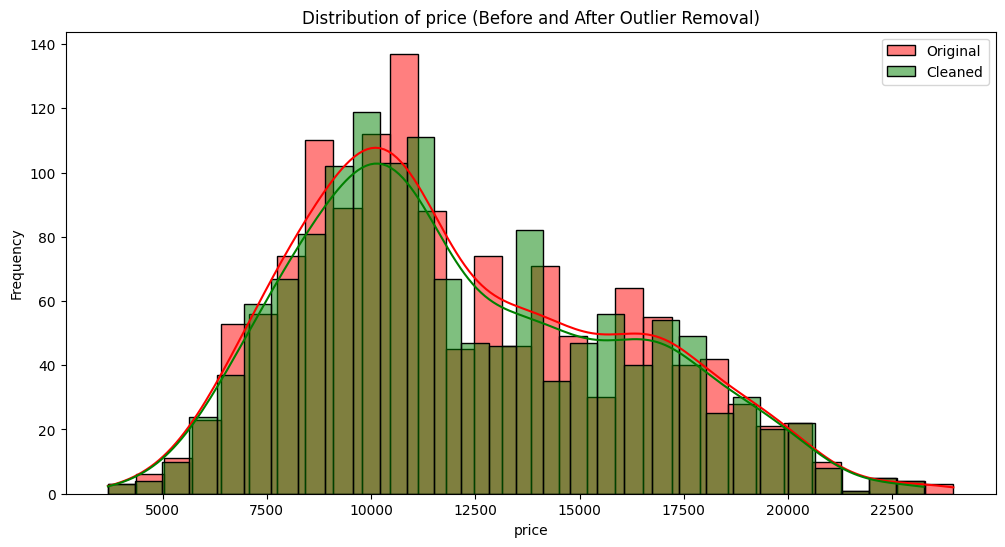

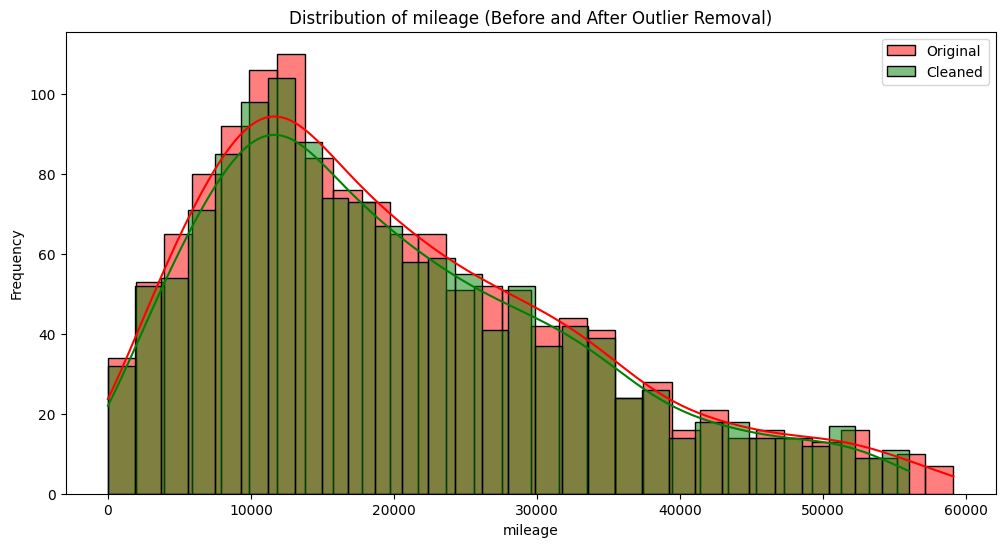

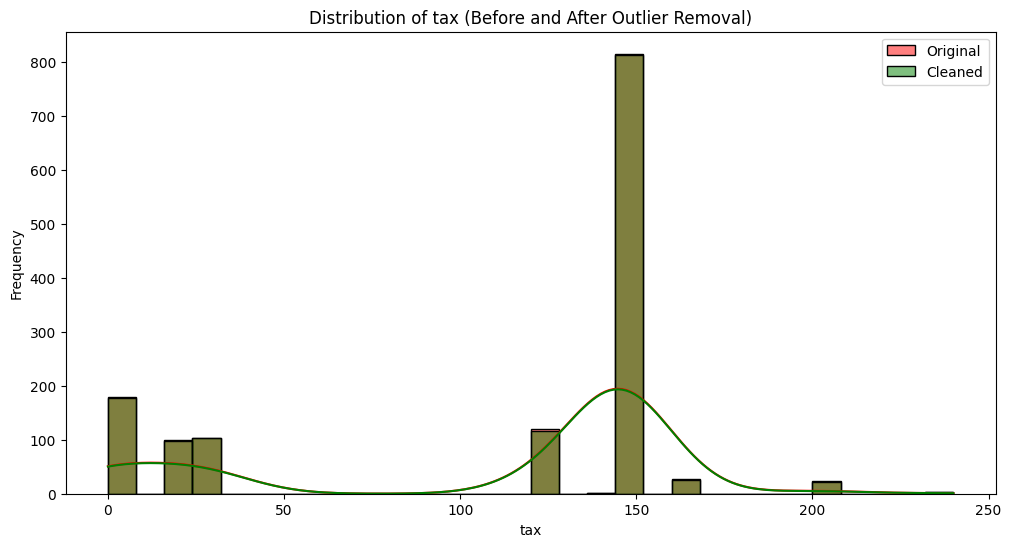

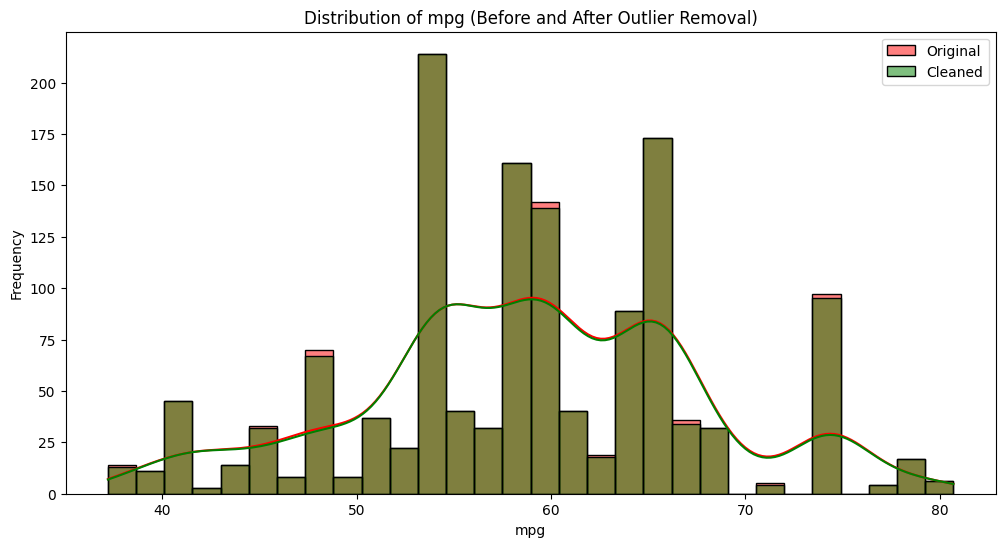

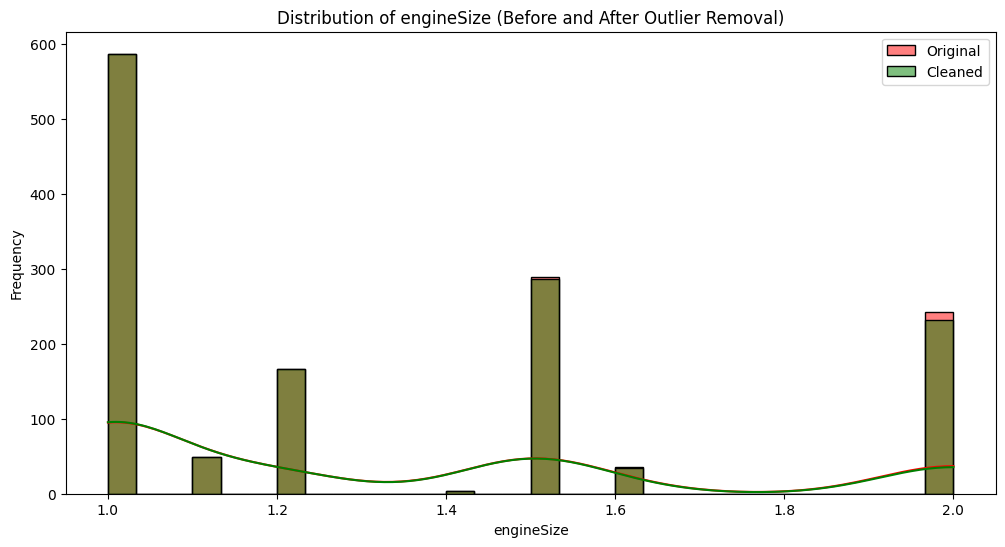

In [49]:
def plot_outliers_removal(df_original, df_cleaned, column):

    plt.figure(figsize=(12, 6))
    
    sns.histplot(df_original[column], kde=True, color="red", label="Original", bins=30, alpha=0.5)
    
    sns.histplot(df_cleaned[column], kde=True, color="green", label="Cleaned", bins=30, alpha=0.5)
    
    plt.title(f"Distribution of {column} (Before and After Outlier Removal)")
    plt.legend()
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.show()

df_original = df.copy()

for col in numerical_cols_to_process:
    if col in df.columns:
        df = remove_outliers_iqr(df, col)

for col in numerical_cols_to_process:
    if col in df.columns:
        plot_outliers_removal(df_original, df, col)


Boxplot of numeric columns:


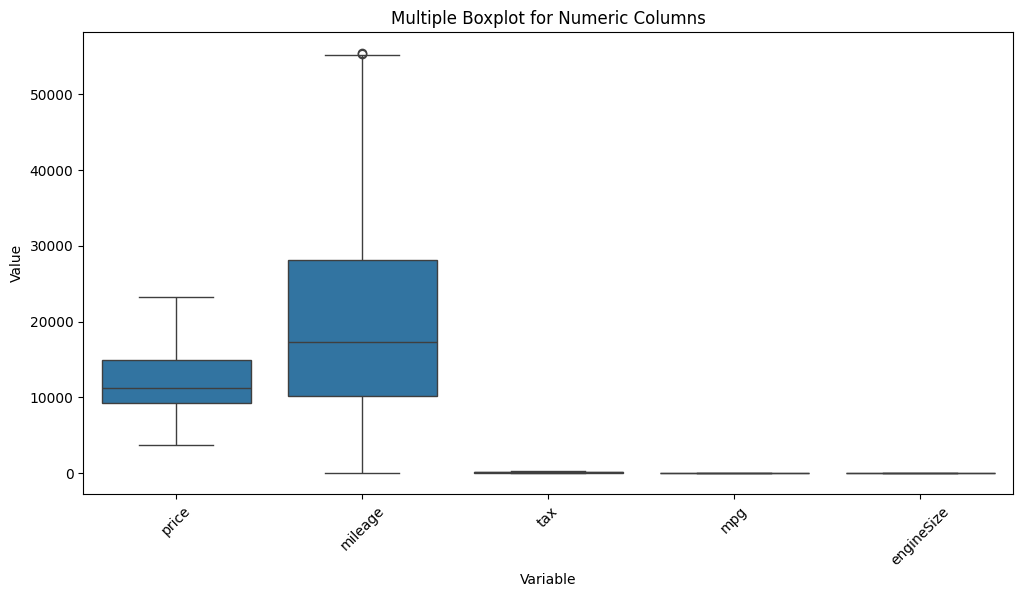

In [51]:
def show_multiple_boxplot(df_, numeric_columns):
    df_melted = df_[numeric_columns].melt(var_name="Variable", value_name="Value")
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(x="Variable", y="Value", data=df_melted)
    plt.title("Multiple Boxplot for Numeric Columns")
    plt.xticks(rotation=45)
    plt.show()

print("\nBoxplot of numeric columns:")
show_multiple_boxplot(df, numerical_cols_to_process)

### 3. Data Preparation